# COVID-19を予測してみましょう

まず、データを読み込み、内容を確認

<BarContainer object of 342 artists>

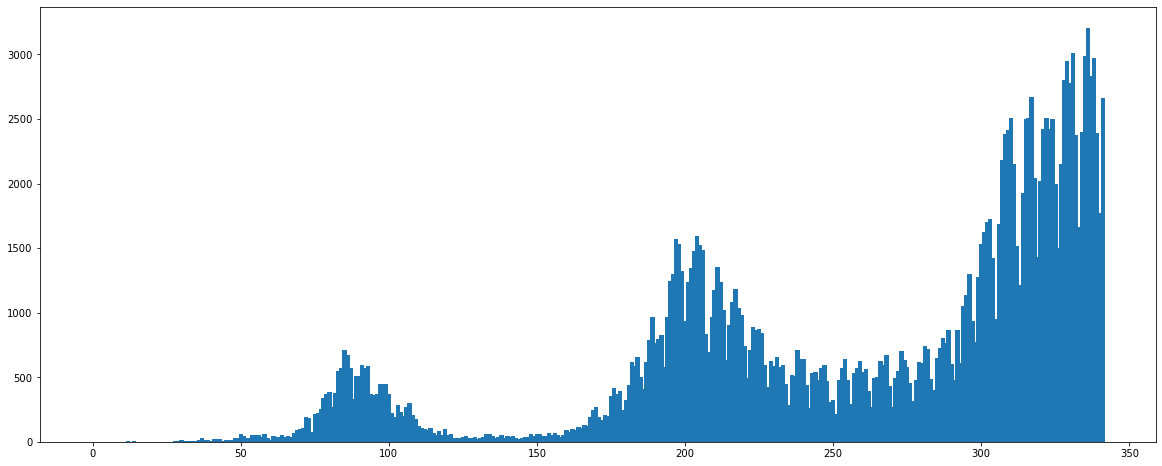

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# データセットから陽性の数のみを読み込む
data_y = np.loadtxt("data/pcr_positive_daily.csv", skiprows=1, delimiter=',', usecols=(1), encoding="utf-8_sig")

# 日付を使えないが、1日毎のデータがあるので、日数を取れる
num_days = len(data_y)
data_x = list(range(num_days))

# 可視化
plt.figure(figsize=(20,8)) 
plt.bar(data_x, data_y, width=1.5)

## AIで処理できるため、正規化などが必要

注意：シークエンスなので、あるデータサンプルから過去を数サンプルを含めて、入力になる

例えば：
```
data_y = [10, 5, 7, 9, 14, 2, 1, 5, 12]
timesteps = 4
```
の場合は：
```
入力(x) = [10, 5, 7, 9], [5, 7, 9, 14], [7, 9, 14, 2]
出力(y) = 14,            2            , 1
```
のような形になる

In [2]:
# データセットを準備。
# ここで「timesteps」は過去データはどれぐらいみるのかという意味
def prepare_dataset(data_y, timesteps):
    
    prep_x = []
    prep_y = []   
    
    for i in range(len(data_x) - timesteps):
        x = data_y[i:i+timesteps]
        y = data_y[i+timesteps]
        prep_x.append(x)
        prep_y.append(y)

    return np.array(prep_x), np.array(prep_y)

In [3]:
timesteps = 7
prep_x, prep_y = prepare_dataset(data_y, timesteps)

In [4]:
# 元のデータ
print(data_y[100:110])

[374. 221. 189. 284. 227. 199. 266. 302. 204. 177.]


In [5]:
# 前処理したあと…
for i in range(100, 105):
    print(prep_x[i], "->", prep_y[i])

[374. 221. 189. 284. 227. 199. 266.] -> 302.0
[221. 189. 284. 227. 199. 266. 302.] -> 204.0
[189. 284. 227. 199. 266. 302. 204.] -> 177.0
[284. 227. 199. 266. 302. 204. 177.] -> 120.0
[227. 199. 266. 302. 204. 177. 120.] -> 106.0


In [6]:
# とはいえ、正規化も必要！
max_count = max(data_y) * 1.5

prep_x /= max_count
prep_y /= max_count

for i in range(100, 105):
    print(prep_x[i], "->", prep_y[i])

[0.07772236 0.04592685 0.03927681 0.05901912 0.04717373 0.04135495
 0.05527847] -> 0.0627597672485453
[0.04592685 0.03927681 0.05901912 0.04717373 0.04135495 0.05527847
 0.06275977] -> 0.04239401496259352
[0.03927681 0.05901912 0.04717373 0.04135495 0.05527847 0.06275977
 0.04239401] -> 0.03678304239401496
[0.05901912 0.04717373 0.04135495 0.05527847 0.06275977 0.04239401
 0.03678304] -> 0.02493765586034913
[0.04717373 0.04135495 0.05527847 0.06275977 0.04239401 0.03678304
 0.02493766] -> 0.02202826267664173


## モデル作成し、学習
LSTM層を使いましょう！

In [7]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model

# LSTMの入力は過去データのシークエンスですので、どれぐらい前をみないといけないのか
# timestepsパラメータで指定する
def create_model(timesteps):
    
    # 入力層の形は（過去データ数、特徴量）
    # 陽性の数しかないので、今回の特徴量は１
    lyr_input = Input(shape=(timesteps, 1))
    
    # 32個のLSTMブロックを使う
    lyr_hiddn = LSTM(32)(lyr_input)
    
    # 最後の出力も数値なので、linear（線形）にする
    lyr_outpt = Dense(units=1, activation="linear")(lyr_hiddn)
    
    model = Model(inputs=lyr_input, outputs=lyr_outpt)
    model.summary()

    model.compile(optimizer="adam", loss="mse")
    
    return model

In [8]:
model = create_model(timesteps)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [9]:
#では、学習へ！
model.fit(prep_x, prep_y, epochs=300)

Epoch 1/300
11/11 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 2/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 3/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 4/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 5/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 6/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 7/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 8/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 9/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 10/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 11/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 12/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 13/300
11/11 [=================

11/11 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 103/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 104/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 105/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 106/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 107/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 108/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 109/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 110/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 111/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 112/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 113/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 114/300
11/11 [=========

11/11 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 203/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 204/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 205/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 206/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 207/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 208/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 209/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 210/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 211/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 212/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 213/300
11/11 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 214/300
11/11 [=========

## 確認：予測と事実を並べて比べる

<BarContainer object of 335 artists>

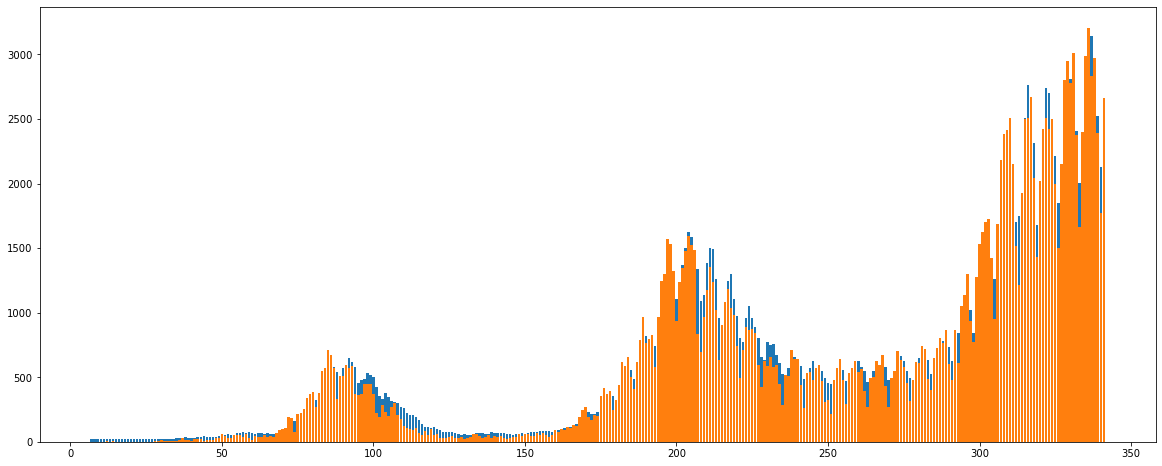

In [10]:
# 入力データそのまま予測する
pred_y = model.predict(prep_x)
pred_y = pred_y.flatten()

# 出力は正規化されているため、もとの数値に戻さないといけない
pred_y = pred_y * max_count

# 並べて比較！
plt.figure(figsize=(20,8)) 
plt.bar(data_x[timesteps:], pred_y)
plt.bar(data_x[timesteps:], data_y[timesteps:])

## 予測してみましょう

注意：事実のデータをベースにして、あくまで１つの数値しか予測できない。したがって、予測の数を１つ以上を望ましい場合、入力データとして予測データを入れる必要があり、数値の信頼性が段々低くなる。

例えば、以下の例で、緑は<span style="color:green">事実</span>, 赤は<span style="color:red">予測</span>をするとしたら…

[<span style="color:green">3, 4, 5, 10, 3</span>] -> <span style="color:red">8</span> 

ここまで予測は信頼できる、ただもう１ステップを進むと…

[<span style="color:green">4, 5, 10, 3,</span> <span style="color:red">8</span>] -> <span style="color:red">12</span> 

シークエンスを進めるため、予測データで埋める必要があり、信頼性が少し落ちます。このまま続けると…

[<span style="color:green">5, 10, 3,</span> <span style="color:red">8, 12</span>] -> <span style="color:red">7</span> 

[<span style="color:green">10, 3,</span> <span style="color:red">8, 12, 7</span>] -> <span style="color:red">4</span> 

[<span style="color:green">3,</span> <span style="color:red">8, 12, 7, 4</span>] -> <span style="color:red">5</span> 

[<span style="color:red">8, 12, 7, 4, 5</span>] -> <span style="color:red">19</span> 

このタイミングで、予測データを使って、予測しているので、信頼性が低くなる。

In [11]:
#この日から、最後のシークエンスを伸ばし、予測してみる
# start_day: スタート日
# last_x: start_dayにあたっての最後のシークエンス
# predict_days: 予測した日数
def predict_sequence(start_day, last_x, predict_days):
    
    future_x = []
    future_y = []
    
    # 1日ごと予測する
    for i in range(predict_days):
        pred_x = np.array([last_x])
        pred_y = model.predict(pred_x)[0]
        
        # last_xを更新する
        last_x = np.hstack((last_x[1:], pred_y))
    
        # 結果を更新
        future_y.append(pred_y)
        future_x.append(start_day + i)
        
    return future_x, future_y

In [12]:
#データの日数
num_days = len(data_x)
print(num_days)

342


In [13]:
#最後の事実シークエンスは：
last_x = prep_x[-1]
print(last_x)

[0.49916874 0.62073982 0.66666667 0.58873649 0.61762261 0.49688279
 0.36907731]


In [14]:
future_x, future_y = predict_sequence(num_days, last_x, 7)

<BarContainer object of 335 artists>

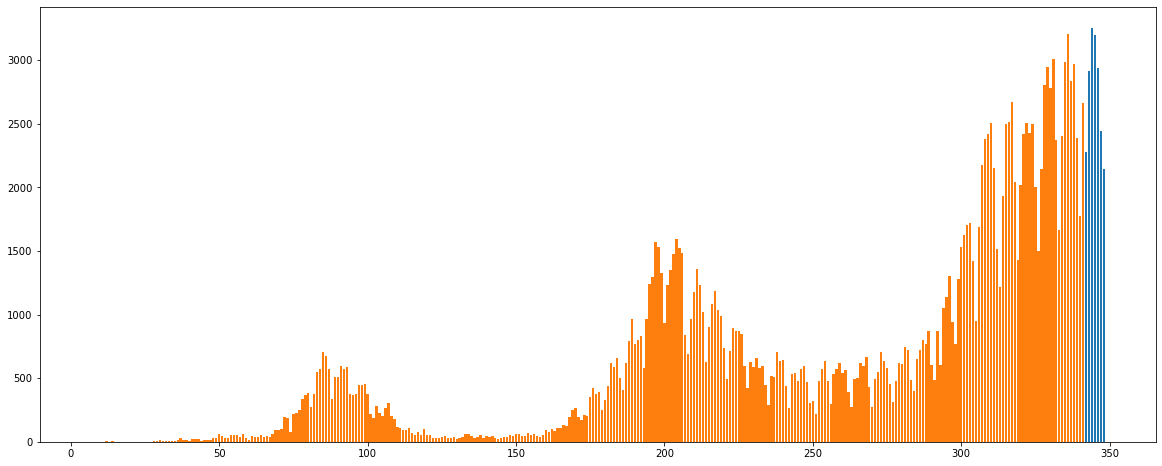

In [15]:
#可視化！
future_y_scale = np.array(future_y).flatten() * max_count

plt.figure(figsize=(20,8)) 
plt.bar(future_x, future_y_scale)
plt.bar(data_x[timesteps:], data_y[timesteps:])

## 遊びの時間

timestepsとpredict_daysをいじれば、どう変わる？